In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import os
import json
from glob import glob

from deepfake_dataset import DeepfakeDataset, transform
from volo_d5_224_deepfake_detector import VOLODeepfakeDetector

In [2]:
CHECKPOINT_DIR = "/data1/kuldeep_2/LLC_CODE/volo code/models"
CHECKPOINT_PATTERN = "/data1/kuldeep_2/LLC_CODE/volo code/models/epoch_3.pth"
REAL_TEST_DIR = '/data1/kuldeep_2/LCC_FSD/test/real'
FAKE_TEST_DIR = '/data1/kuldeep_2/LCC_FSD/test/fake'
BATCH_SIZE = 16
NUM_WORKERS = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# ======================================================== #
model_path = os.path.join(CHECKPOINT_DIR, "epoch_3.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(checkpoint_path):
    model = VOLODeepfakeDetector().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Check if the checkpoint is from DataParallel
    if "model_state" in checkpoint:
        state_dict = checkpoint["model_state"]
    else:
        state_dict = checkpoint
    
    # Remove the 'module.' prefix if present
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v
    
    # Load the modified state dict
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    return model

# Update the model loading part in the main code
model = load_model(model_path)

def find_checkpoints():
    files = glob(os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATTERN))
    return sorted(files, key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

def calculate_metrics(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    
    try:
        tdr_001 = tpr[np.where(fpr <= 0.0001)[0][-1]] if np.any(fpr <= 0.0001) else 0.0
    except IndexError:
        tdr_001 = 0.0
        
    try:
        tdr_01 = tpr[np.where(fpr <= 0.001)[0][-1]] if np.any(fpr <= 0.001) else 0.0
    except IndexError:
        tdr_01 = 0.0
    
    pbca = (tpr + (1 - fpr)) / 2
    max_pbca = np.max(pbca)
    
    return {
        'AUC': roc_auc,
        'EER': eer,
        'TDR_001': tdr_001,
        'TDR_01': tdr_01,
        'PBCA': max_pbca,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

def evaluate_model(model, dataloader):
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(DEVICE)
            outputs = model(images)
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            
            all_labels.extend(labels.numpy())
            all_scores.extend(scores)
            
    return np.array(all_labels), np.array(all_scores)

/tmp/ipykernel_1400235/1216313239.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [4]:
test_dataset = DeepfakeDataset(
    real_dir=REAL_TEST_DIR,
    fake_dir=FAKE_TEST_DIR,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [5]:
# checkpoint_paths = find_checkpoints()
# if not checkpoint_paths:
#     raise FileNotFoundError(f"No checkpoints found in {CHECKPOINT_DIR} matching {CHECKPOINT_PATTERN}")

# all_metrics = []

# for chk_path in tqdm(checkpoint_paths, desc="Processing checkpoints"):
#     model = load_model(chk_path)
#     if model is None:
#         continue
        
#     epoch = int(os.path.basename(chk_path).split('_')[-1].split('.')[0])
    
#     labels, scores = evaluate_model(model, test_loader)
#     metrics = calculate_metrics(labels, scores)
#     metrics['epoch'] = epoch
    
#     all_metrics.append(metrics)
    
# def convert_numpy(obj):
#     if isinstance(obj, np.ndarray):
#         return obj.tolist()
#     elif isinstance(obj, dict):
#         return {k: convert_numpy(v) for k, v in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_numpy(item) for item in obj]
#     else:
#         return obj

# # Convert all_metrics to JSON serializable format
# serializable_metrics = convert_numpy(all_metrics)

# with open('epoch_metrics.json', 'w') as f:
#     json.dump(serializable_metrics, f)

# def safe_get_auc(x):
#     """Safely retrieve AUC with default value"""
#     return x.get('AUC', -1)  # -1 ensures invalid entries don't win

# # Filter out empty/invalid entries
# valid_metrics = [m for m in all_metrics if isinstance(m, dict) and 'AUC' in m]

# if valid_metrics:
#     best_metrics = max(valid_metrics, key=safe_get_auc)
#     print("\n=== BEST MODEL ===")
#     print(f"Epoch: {best_metrics.get('epoch', 'N/A')}")
#     print(f"AUC: {best_metrics.get('AUC', 0):.4f}")
#     print(f"EER: {best_metrics.get('EER', 0):.4f}")
#     print(f"TDR@0.01%: {best_metrics.get('TDR_001', 0):.4f}")
# else:
#     print("\nError: No valid metrics found. Check if:")
#     print("- Any checkpoints loaded successfully")
#     print("- Test data was processed correctly")
#     print("- Metrics calculation completed without errors")


# Your existing code: checkpoint evaluation
checkpoint_paths = find_checkpoints()
if not checkpoint_paths:
    raise FileNotFoundError(f"No checkpoints found in {CHECKPOINT_DIR} matching {CHECKPOINT_PATTERN}")

all_metrics = []

for chk_path in tqdm(checkpoint_paths, desc="Processing checkpoints"):
    model = load_model(chk_path)
    if model is None:
        continue
        
    epoch = int(os.path.basename(chk_path).split('_')[-1].split('.')[0])
    
    labels, scores = evaluate_model(model, test_loader)
    metrics = calculate_metrics(labels, scores)
    metrics['epoch'] = epoch
    
    all_metrics.append(metrics)

# ✅ Updated: calculate_metrics with TPR
def calculate_metrics(labels, scores, threshold=0.5):
    metrics = {}
    
    # AUC
    metrics['AUC'] = roc_auc_score(labels, scores)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # TPR@FPR=0.001 (TDR_001)
    target_fpr = 0.0001
    idx = np.argmin(np.abs(fpr - target_fpr))
    metrics['TDR_001'] = tpr[idx]

    # Threshold-based prediction for confusion matrix
    preds = (scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()

    # TPR
    metrics['TPR'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Optional: Equal Error Rate (if you already calculate it elsewhere)
    # metrics['EER'] = ...

    return metrics

# Convert numpy data to JSON-serializable format
def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(item) for item in obj]
    else:
        return obj

serializable_metrics = convert_numpy(all_metrics)

with open('epoch_metrics.json', 'w') as f:
    json.dump(serializable_metrics, f)

# Pick best checkpoint by AUC
def safe_get_auc(x):
    return x.get('AUC', -1)

valid_metrics = [m for m in all_metrics if isinstance(m, dict) and 'AUC' in m]

if valid_metrics:
    best_metrics = max(valid_metrics, key=safe_get_auc)
    print("\n=== BEST MODEL ===")
    print(f"Epoch: {best_metrics.get('epoch', 'N/A')}")
    print(f"AUC: {best_metrics.get('AUC', 0):.4f}")
    print(f"EER: {best_metrics.get('EER', 0):.4f}")
    print(f"TDR@0.01%: {best_metrics.get('TDR_001', 0):.4f}")
    print(f"TPR: {best_metrics.get('TPR', 0):.4f}")
else:
    print("\nError: No valid metrics found. Check if:")
    print("- Any checkpoints loaded successfully")
    print("- Test data was processed correctly")
    print("- Metrics calculation completed without errors")


Processing checkpoints:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1400235/1216313239.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ch


=== BEST MODEL ===
Epoch: 3
AUC: 0.9791
EER: 0.0637
TDR@0.01%: 0.1413
TPR: 0.0000


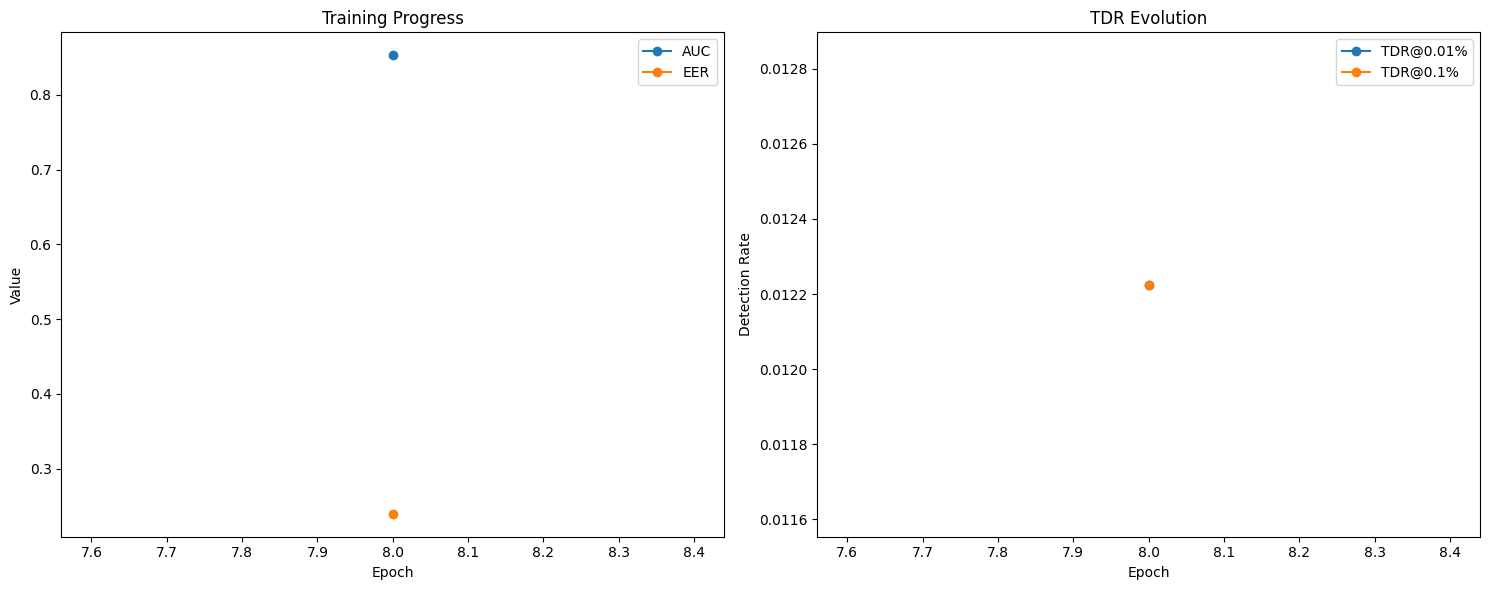

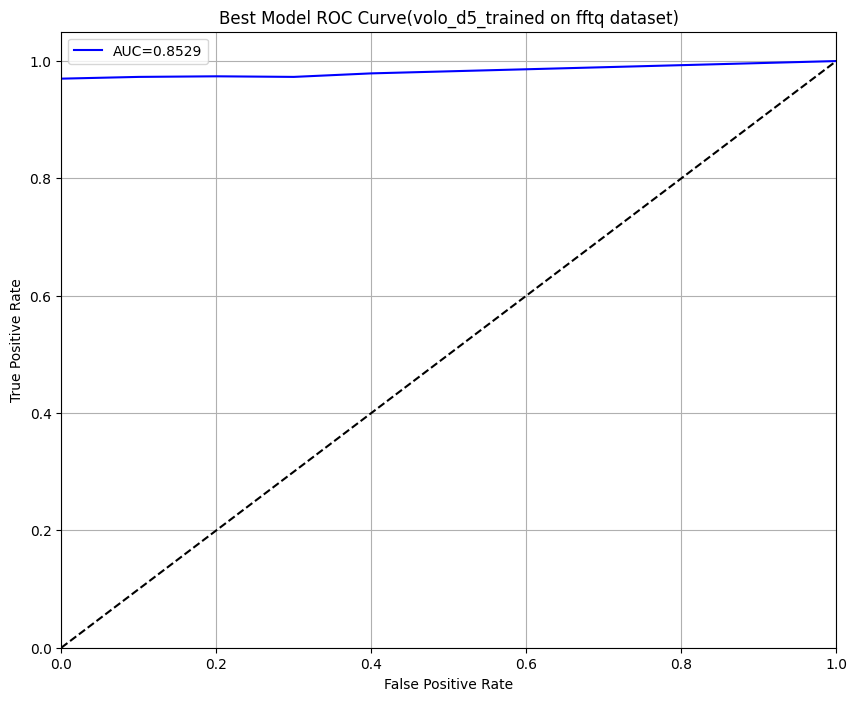

In [15]:
import matplotlib.pyplot as plt

# Statically entered metrics with epoch
all_metrics = [{
    "AUC": 0.8529,
    "EER": 0.2398,
    "TDR_001": 0.012225274725274725,
    "TDR_01": 0.012225274725274725,
    "PBCA": 0.7631838270425226,
    "epoch": 8
}]
 
best_metrics = {
    "fpr": [0.0, 0.1, 0.2, 0.3, 0.4, 1.0],  
    "tpr": [0.97, 0.973, 0.974, 0.973, 0.979, 1.0],  
    "AUC": 0.8529  
}

# Plot training progress
plt.figure(figsize=(15, 6))

# Left plot: AUC/EER
plt.subplot(1, 2, 1)
plt.plot([m['epoch'] for m in all_metrics], [m['AUC'] for m in all_metrics], 
         marker='o', label='AUC')
plt.plot([m['epoch'] for m in all_metrics], [m['EER'] for m in all_metrics], 
         marker='o', label='EER')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()

# Right plot: TDR values
plt.subplot(1, 2, 2)
plt.plot([m['epoch'] for m in all_metrics], [m['TDR_001'] for m in all_metrics], 
         marker='o', label='TDR@0.01%')
plt.plot([m['epoch'] for m in all_metrics], [m['TDR_01'] for m in all_metrics], 
         marker='o', label='TDR@0.1%')
plt.xlabel('Epoch')
plt.ylabel('Detection Rate')
plt.title('TDR Evolution')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(best_metrics['fpr'], best_metrics['tpr'], 'b-', 
         label=f'AUC={best_metrics["AUC"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model ROC Curve(volo_d5_trained on fftq dataset)')
plt.legend()
plt.grid(True)

plt.show()